In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from joblib import dump


# Function to convert timestamp to total seconds
def convert_timestamp_to_seconds(timestamp):
    minutes, seconds = timestamp.split(':')
    return float(minutes) * 60 + float(seconds)

# Function to preprocess the dataset
def preprocess_dataset(file_path, numerical_cols, categorical_cols, timestamp_col, preprocessor=None):
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Convert timestamp to seconds and add as a new column
    df[timestamp_col + '_sec'] = df[timestamp_col].apply(convert_timestamp_to_seconds)
    
    # Add the new timestamp seconds column to numerical columns
    numerical_cols = numerical_cols + [timestamp_col + '_sec']
    
    # If a preprocessor is provided, use it, otherwise create a new one
    if preprocessor is None:
        # Pipeline for numerical features
        numerical_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])
        
        # Pipeline for categorical features
        categorical_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))
        ])
        
        # Combine both pipelines into a ColumnTransformer
        preprocessor = ColumnTransformer([
            ('num', numerical_pipeline, numerical_cols),
            ('cat', categorical_pipeline, categorical_cols)
        ])
        
        # Fit the preprocessor on the current dataset
        preprocessor.fit(df)
    
    # Apply the preprocessor to the dataframe
    processed_data = preprocessor.transform(df)
    
    # Get feature names for numerical columns and one-hot encoded categorical columns
    feature_names = numerical_cols + list(preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_cols))
    
    # Create a DataFrame with the processed data and the correct column names
    df_processed = pd.DataFrame(processed_data, columns=feature_names)
    
    return df_processed, preprocessor

# Define columns common to both normal and anomaly datasets
numerical_cols_common = ['srcPort', 'dstPort', 'ipLen','Relative Time']  # 'Relative Time' will be added after conversion
categorical_cols_common = ['srcIP', 'dstIP']
timestamp_col = 'TimeStamp'  # Adjust this if the name of your timestamp column is different

# Paths to the datasets
paths = {
    'normal_traffic': '/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/normal_traffic_updated.csv',
    'normal_gics': '/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/gics_normal_updated.csv',
    'normal_scada':'/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/scade_normal_traffic.csv',
    'normal_inside_station':'/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/inside_station_normal_updated.csv',
    'inside_station_attack':'/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/inside_substation_Attack_updated.csv',
    'injection_attack': '/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/injection_attack_updated.csv',
    'gis_lost_connection': '/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/gics_lost_connection_updated.csv'
}

all_dfs = []  # List to hold all processed DataFrames
preprocessor = None  # Initialize preprocessor

# Process each dataset and label accordingly
for label, path in paths.items():
    df_processed, preprocessor = preprocess_dataset(
        path, 
        numerical_cols_common, 
        categorical_cols_common, 
        timestamp_col, 
        preprocessor=preprocessor
    )
    
    # Assign label (0 for 'normal', 1 for 'attack')
    df_processed['label'] = 0 if 'normal' in label else 1
    
    all_dfs.append(df_processed)

# Combine all DataFrames into one
combined_df = pd.concat(all_dfs, ignore_index=True)

# Now save the preprocessor to a file
preprocessor_output_file_path = '/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/preprocessor.joblib'
dump(preprocessor, preprocessor_output_file_path)

# Specify the output file path
output_file_path = '/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/combined_normal_anamoly_traffic.csv'

# Save the combined DataFrame to a CSV file
combined_df.to_csv(output_file_path, index=False)

print(f'Combined dataset saved to {output_file_path}')

/Users/shaiksaheer/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Combined dataset saved to /Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/combined_normal_anamoly_traffic.csv


## EDA (Exploratory Data Analysis)

Statistical Summary:
             srcPort        dstPort          ipLen  Relative Time  \
count  127776.000000  127776.000000  127776.000000  127776.000000   
mean       -0.008446      -0.028192       2.177026      -0.130771   
std         0.993566       0.997771      10.907882       1.060994   
min        -0.763277      -1.556672      -1.817516      -1.709591   
25%        -0.679113      -1.472508      -1.325561      -1.080099   
50%        -0.679113       0.679113       0.740651      -0.166584   
75%         1.472508       0.679113       0.740651       0.788758   
max         1.580875       0.787481     154.919402       1.701702   

       TimeStamp_sec  srcIP_192.168.11.111  srcIP_192.168.11.248  \
count  127776.000000         127776.000000         127776.000000   
mean        0.023853              0.291017              0.631378   
std         0.989918              0.454233              0.482433   
min        -1.729396              0.000000              0.000000   
25%        -0.827

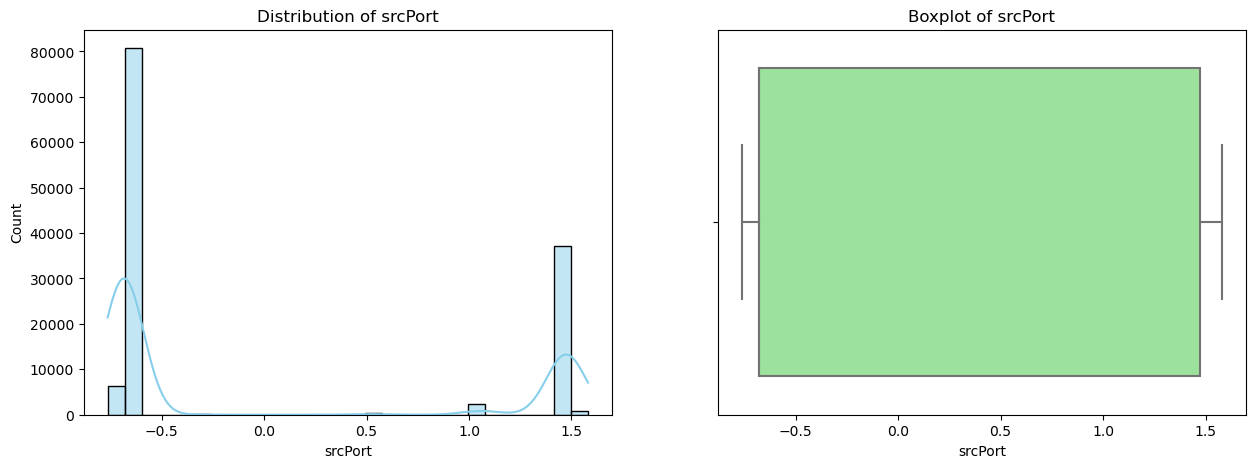

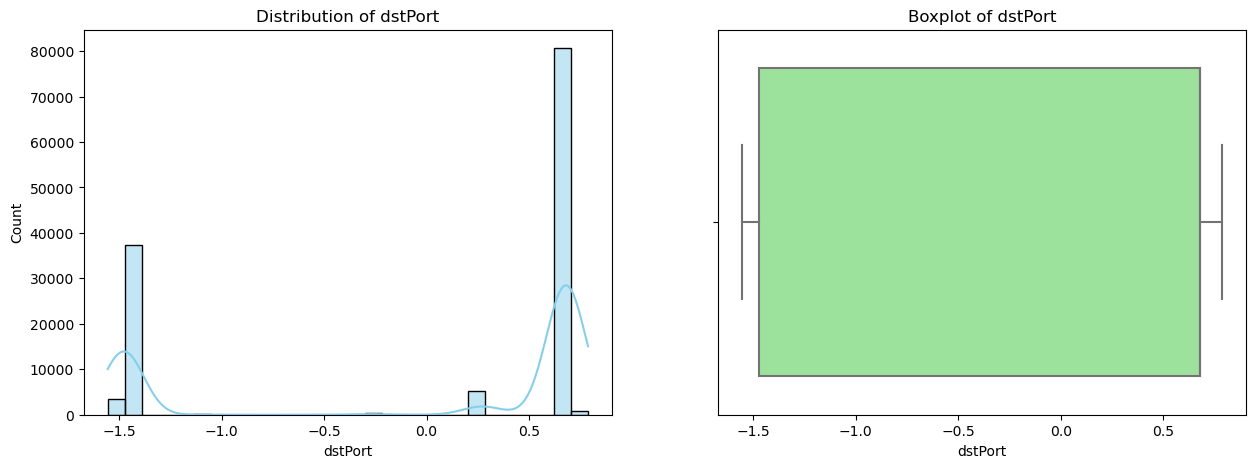

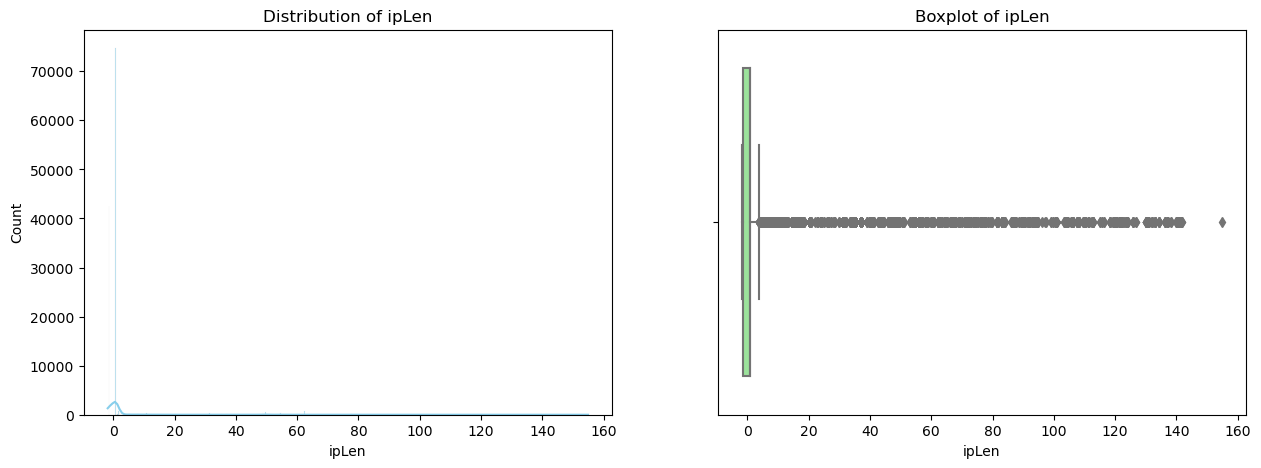

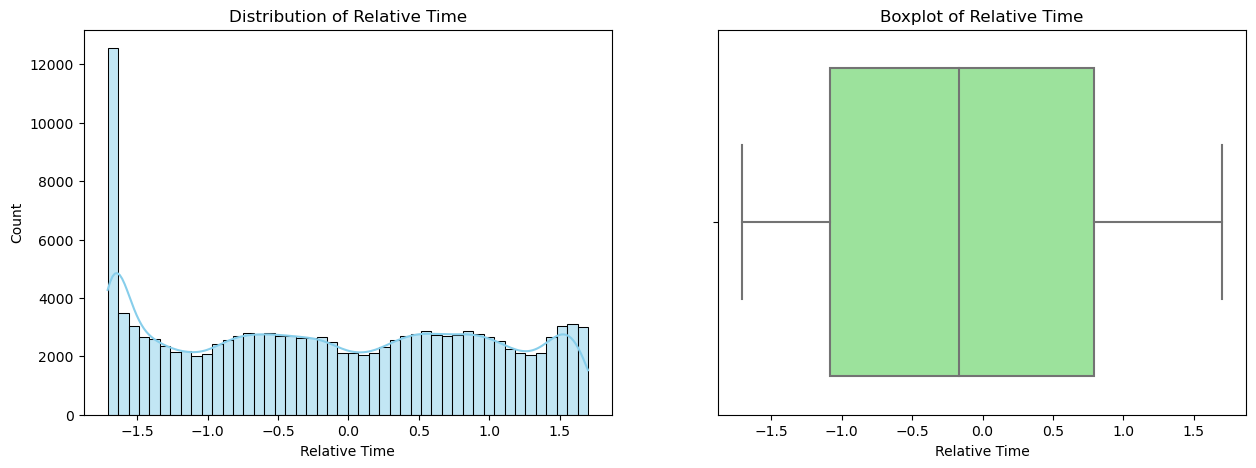

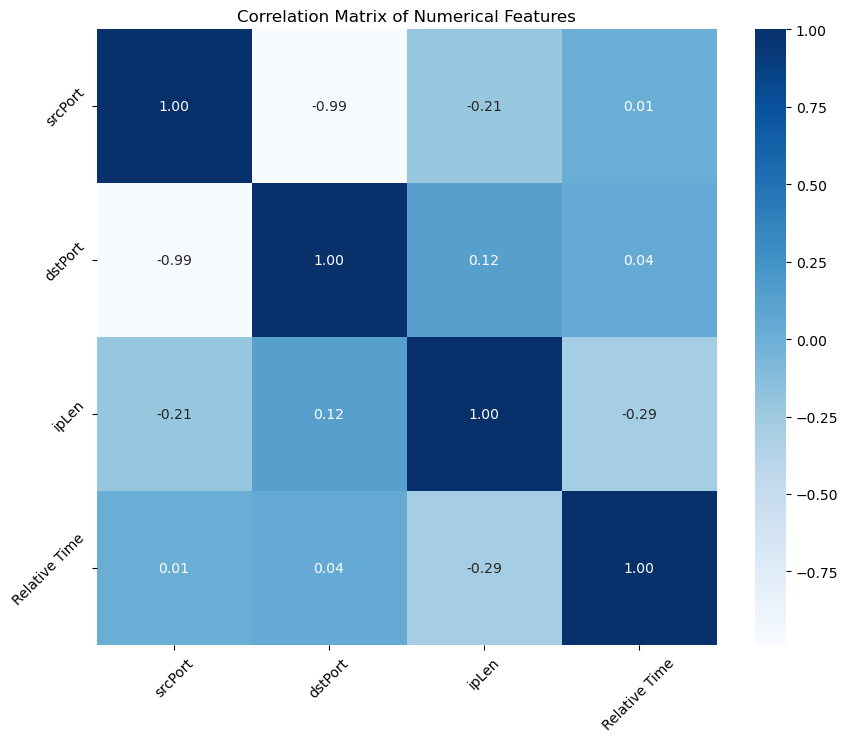

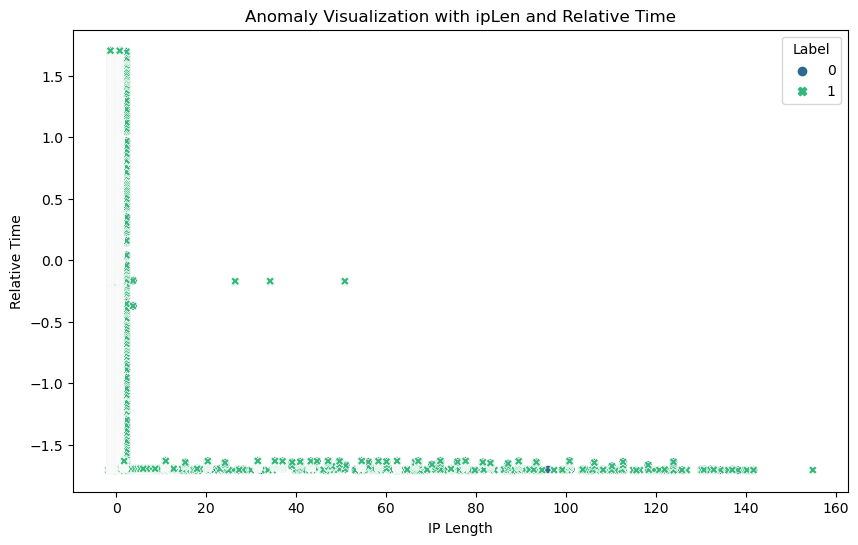

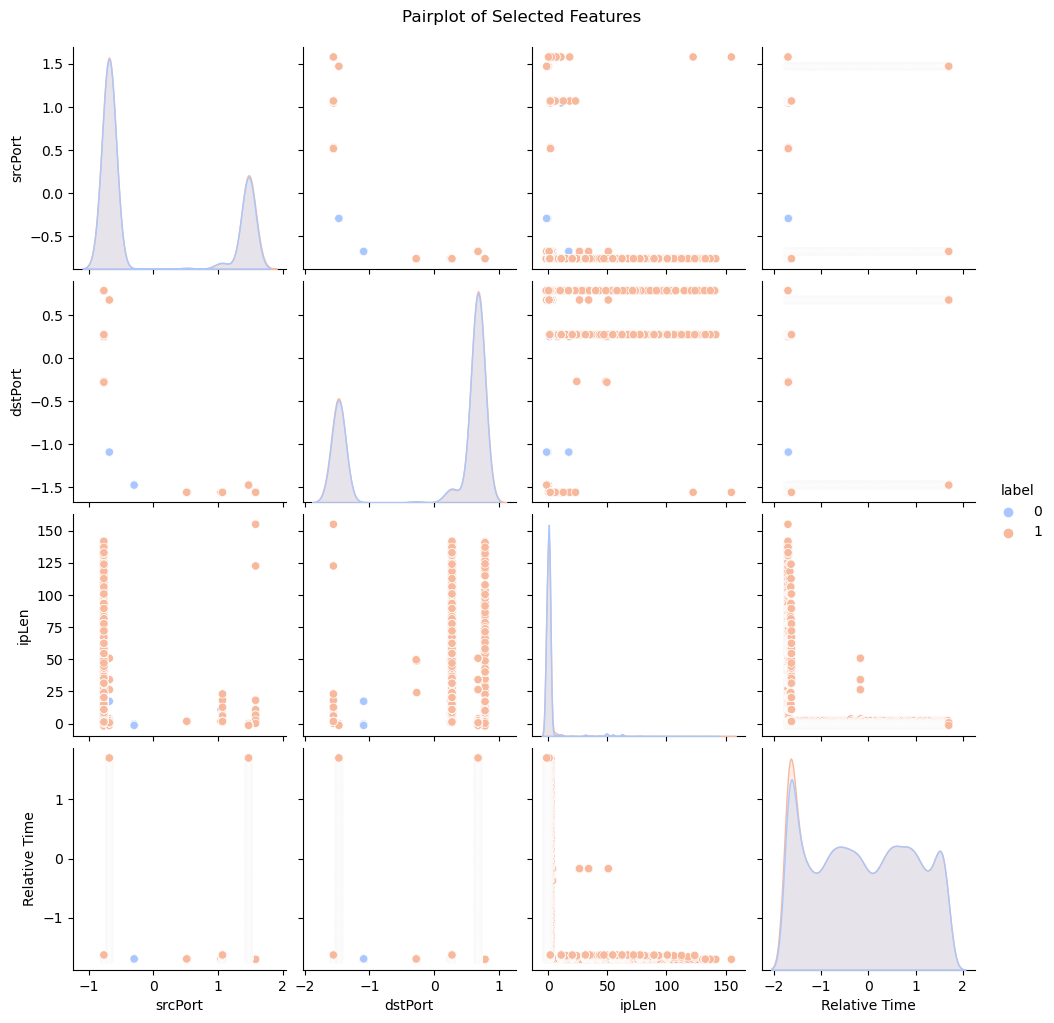

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed dataset
df = pd.read_csv('/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/combined_normal_anamoly_traffic.csv')

# Statistical Summary for numerical columns
print("Statistical Summary:")
print(df.describe())

# Distribution of Variables: Histograms and Boxplots for numerical columns
num_cols = ['srcPort', 'dstPort', 'ipLen', 'Relative Time']

# Plot histograms and boxplots for each numerical column
for col in num_cols:
    plt.figure(figsize=(15, 5))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
    
    plt.show()

# Correlation Analysis: Correlation Matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df[num_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Anomaly Visualization
# Choosing 'ipLen' and 'Relative Time' for scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='ipLen', y='Relative Time', hue='label', style='label', palette='viridis')
plt.title('Anomaly Visualization with ipLen and Relative Time')
plt.xlabel('IP Length')
plt.ylabel('Relative Time')
plt.legend(title='Label')
plt.show()

# Pairplot for selected features and label
selected_features = ['srcPort', 'dstPort', 'ipLen', 'Relative Time', 'label']
sns.pairplot(df[selected_features], hue='label', palette='coolwarm')
plt.suptitle('Pairplot of Selected Features', y=1.02)
plt.show()


## Feature Selection

In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

# Load your dataset
df = pd.read_csv('/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/combined_normal_anamoly_traffic.csv')

# Split your data into features and target
X = df.drop('label', axis=1)  # replace 'label' with your actual target column name
y = df['label']

# Feature Importance with Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, y)
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Selecting features based on importance
selector = SelectFromModel(rf, prefit=True)
X_reduced_rf = selector.transform(X)

# Dimensionality Reduction with PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_reduced_pca = pca.fit_transform(X)

# Save the trained PCA model
pca_model_path = '/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/trained_pca.joblib'
dump(pca, pca_model_path)

# Generate dynamic column names based on the number of PCA components
pca_columns = [f'PCA_Component_{i+1}' for i in range(X_reduced_pca.shape[1])]

# Create a DataFrame for the PCA-reduced data
df_pca_reduced = pd.DataFrame(X_reduced_pca, columns=pca_columns)
df_pca_reduced['label'] = y  # Add the labels back for reference

# Specify the output file path for the PCA-reduced dataset
output_pca_file_path = '/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/PCA_combined_traffic.csv'

# Save the PCA-reduced DataFrame to a CSV file
df_pca_reduced.to_csv(output_pca_file_path, index=False)

print(f'PCA-reduced dataset saved to {output_pca_file_path}')

# Get the PCA loadings (coefficients)
loadings = pca.components_

# Create a DataFrame of loadings with feature names as columns
loadings_df = pd.DataFrame(loadings, columns=X.columns, index=pca_columns)


# Print the feature importances, reduced dataset shapes, and PCA loadings
print("Feature Importances:\n", feature_importances)
print("\nReduced dataset shape after feature selection (Random Forest):", X_reduced_rf.shape)
print("Reduced dataset shape after PCA:", X_reduced_pca.shape)
print("\nPCA Loadings:\n", loadings_df)


/Users/shaiksaheer/anaconda3/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


PCA-reduced dataset saved to /Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/PCA_combined_traffic.csv
Feature Importances:
 Relative Time           0.479849
TimeStamp_sec           0.476656
ipLen                   0.018280
dstPort                 0.012287
srcPort                 0.009781
srcIP_192.168.11.248    0.001033
dstIP_192.168.11.111    0.000949
dstIP_192.168.11.248    0.000622
srcIP_192.168.11.111    0.000542
dtype: float64

Reduced dataset shape after feature selection (Random Forest): (127776, 2)
Reduced dataset shape after PCA: (127776, 1)

PCA Loadings:
                   srcPort   dstPort     ipLen  Relative Time  TimeStamp_sec  \
PCA_Component_1 -0.019513  0.011467  0.999212      -0.027961       0.002626   

                 srcIP_192.168.11.111  srcIP_192.168.11.248  \
PCA_Component_1              -0.00867             -0.007852   

                 dstIP_192.168.11.111  dstIP_192.168.11.248  
PCA_Component_1        

## Model Development and Anomaly Detection

## Isolation Forest

In [5]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


# Assuming X and y are your data and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

# Fit the model on the training data
iso_forest.fit(X_train)

# The anomaly scores are the opposite of the anomaly scores given by the model
y_pred_train = iso_forest.predict(X_train)
y_pred_test = iso_forest.predict(X_test)

# Remap the prediction labels to match your dataset labels
# Isolation Forest uses -1 for outliers, which we consider anomalies, and 1 for inliers (normal)
y_pred_train = [0 if i == 1 else 1 for i in y_pred_train]
y_pred_test = [0 if i == 1 else 1 for i in y_pred_test]

# Evaluate the model
print("Classification Report (Train):")
print(classification_report(y_train, y_pred_train))
print("Confusion Matrix (Train):\n", confusion_matrix(y_train, y_pred_train))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, y_pred_test))


Classification Report (Train):
              precision    recall  f1-score   support

           0       0.50      0.63      0.56     50555
           1       0.51      0.38      0.44     51665

    accuracy                           0.51    102220
   macro avg       0.51      0.51      0.50    102220
weighted avg       0.51      0.51      0.50    102220

Confusion Matrix (Train):
 [[31998 18557]
 [32033 19632]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.51      0.63      0.56     12766
           1       0.51      0.39      0.44     12790

    accuracy                           0.51     25556
   macro avg       0.51      0.51      0.50     25556
weighted avg       0.51      0.51      0.50     25556

Confusion Matrix (Test):
 [[8022 4744]
 [7838 4952]]


## Encoder

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Load dataset
df = pd.read_csv('/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/PCA_combined_traffic.csv')

# Prepare data for Autoencoder
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Autoencoder architecture
input_dim = X_train_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(64, activation="relu")(input_layer)
encoder = Dense(32, activation="relu")(encoder)
encoder = Dense(16, activation="relu")(encoder)
decoder = Dense(32, activation='relu')(encoder)
decoder = Dense(64, activation='relu')(decoder)
decoder = Dense(input_dim, activation='linear')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile and train the model
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=32, shuffle=True, validation_data=(X_test_scaled, X_test_scaled))

# Predictions and reconstruction error
predictions = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_test})

# Determine the threshold for anomaly
threshold = np.quantile(error_df['Reconstruction_error'], 0.95)  # Adjust this threshold based on your requirement

# Classify as anomaly if reconstruction error is higher than the threshold
error_df['Prediction'] = [1 if e > threshold else 0 for e in error_df['Reconstruction_error']]

# Evaluation
print("Classification Report:")
print(classification_report(error_df['True_class'], error_df['Prediction']))

roc_auc = roc_auc_score(error_df['True_class'], error_df['Prediction'])
print("ROC-AUC Score:", roc_auc)


Epoch 1/50
3195/3195 [==============================] - 3s 753us/step - loss: 3.3888e-05 - val_loss: 3.8833e-08
Epoch 2/50
3195/3195 [==============================] - 2s 714us/step - loss: 2.5848e-06 - val_loss: 1.6548e-06
Epoch 3/50
3195/3195 [==============================] - 3s 1ms/step - loss: 4.2019e-06 - val_loss: 9.6260e-05
Epoch 4/50
3195/3195 [==============================] - 3s 906us/step - loss: 1.9248e-06 - val_loss: 3.9741e-07
Epoch 5/50
3195/3195 [==============================] - 2s 692us/step - loss: 1.7017e-06 - val_loss: 5.8494e-06
Epoch 6/50
3195/3195 [==============================] - 2s 677us/step - loss: 2.1176e-06 - val_loss: 1.6741e-08
Epoch 7/50
3195/3195 [==============================] - 2s 682us/step - loss: 7.9352e-07 - val_loss: 1.0237e-08
Epoch 8/50
3195/3195 [==============================] - 3s 825us/step - loss: 2.7609e-06 - val_loss: 1.2320e-07
Epoch 9/50
3195/3195 [==============================] - 2s 698us/step - loss: 1.0730e-06 - val_loss: 2.729

## Oneclass SVM

In [7]:
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Load dataset
df = pd.read_csv('/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/PCA_combined_traffic.csv')

# Assume all your data is labeled and you are using a supervised approach to train an unsupervised model
# Split your data into 'normal' and 'anomalous'
df_normal = df[df['label'] == 0]  # Assuming 0 is for normal class
df_anomaly = df[df['label'] == 1]  # Assuming 1 is for anomaly class

# We will only use normal data to train the One-Class SVM
X_train = df_normal.drop('label', axis=1)

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Initialize One-Class SVM model
oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)  # nu is an upper bound on the fraction of training errors

# Fit the model
oc_svm.fit(X_train_scaled)

# Predict the training set to find the decision boundary
y_train_pred = oc_svm.predict(X_train_scaled)

# Apply the same scaling to the entire dataset for a fair comparison
X_scaled = scaler.transform(df.drop('label', axis=1))
y = df['label']

# Predict on the entire dataset
y_pred = oc_svm.predict(X_scaled)

# Convert prediction labels to binary (0: normal, 1: anomaly)
y_pred = [0 if i == 1 else 1 for i in y_pred]

# Evaluate model performance
print("Classification Report:")
print(classification_report(y, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))

# You may also want to look at the scores to decide on a threshold
scores = oc_svm.score_samples(X_scaled)

# Save the model scores for further analysis if needed
df['scores'] = scores


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.95      0.65     63321
           1       0.52      0.05      0.10     64455

    accuracy                           0.50    127776
   macro avg       0.51      0.50      0.37    127776
weighted avg       0.51      0.50      0.37    127776

Confusion Matrix:
 [[60155  3166]
 [61052  3403]]


## KNN (K Nearest Neighbors)

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/PCA_combined_traffic.csv')

# Split dataset into features (X) and target variable (y)
X = df.drop('label', axis=1)  # Replace 'label' with your actual target column name
y = df['label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (important for KNN)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can change n_neighbors based on your requirement

# Train the classifier
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.24      0.24     12766
           1       0.25      0.26      0.26     12790

    accuracy                           0.25     25556
   macro avg       0.25      0.25      0.25     25556
weighted avg       0.25      0.25      0.25     25556

Confusion Matrix:
[[3062 9704]
 [9490 3300]]
Accuracy Score: 0.24894349663484114


## XGboost

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Load dataset
df = pd.read_csv('/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/PCA_combined_traffic.csv')

# Define features and target
X = df.drop('label', axis=1)
y = df['label']

# Split the data into training and test sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the stratified k-fold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Create a pipeline with SMOTE and XGBoost
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Define a grid of parameters to search
param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_child_weight': [1, 3, 5],
    'classifier__gamma': [0, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

# Grid search with stratified cross-validation
grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=stratified_kfold, verbose=2)
grid_search.fit(X_train, y_train)

# Use the best estimator found by the grid search
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__max_depth=3, classifier__min_child_weight=1, classifier__subsample=0.8; total time=   0.4s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__max_depth=3, classifier__min_child_weight=1, classifier__subsample=0.8; total time=   0.5s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__max_depth=3, classifier__min_child_weight=1, classifier__subsample=0.8; total time=   0.5s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__max_depth=3, classifier__min_child_weight=1, classifier__subsample=1.0; total time=   0.3s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__max_depth=3, classifier__min_child_weight=1, classifier__subsample=1.0; total time=   0.3s
[CV] END classifier__colsample_bytree=0.8, classifier__gamma=0, classifier__max_depth=3, classifier__m

## Ridge Regression with random forest classifier

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Load dataset
df = pd.read_csv('/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/PCA_combined_traffic.csv')

# Define features and target
X = df.drop('label', axis=1)
y = df['label']

# Split the data into training and test sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the 10-fold stratified cross-validation
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize Ridge Regression Classifier
ridge_clf = RidgeClassifier()

# Initialize Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Cross-validation for Ridge Classifier
ridge_cv_scores = cross_val_score(ridge_clf, X_train, y_train, cv=stratified_kfold, scoring='roc_auc')

# Cross-validation for Random Forest Classifier
rf_cv_scores = cross_val_score(rf_clf, X_train, y_train, cv=stratified_kfold, scoring='roc_auc')

# Train the Ridge Classifier on the entire training set
ridge_clf.fit(X_train, y_train)

# Train the Random Forest Classifier on the entire training set
rf_clf.fit(X_train, y_train)

# Make predictions with both models on the test set
ridge_pred = ridge_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)

# Evaluate the Ridge Classifier
print("Ridge Regression CV ROC-AUC Scores:", ridge_cv_scores)
print("\nRidge Classifier Classification Report:")
print(classification_report(y_test, ridge_pred))
print("Ridge Classifier ROC-AUC Score:", roc_auc_score(y_test, ridge_pred))

# Evaluate the Random Forest Classifier
print("Random Forest CV ROC-AUC Scores:", rf_cv_scores)
print("\nRandom Forest Classifier Classification Report:")
print(classification_report(y_test, rf_pred))
print("Random Forest Classifier ROC-AUC Score:", roc_auc_score(y_test, rf_pred))


KeyboardInterrupt: 

## LOF

In [12]:
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Load dataset
df = pd.read_csv('/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/PCA_combined_traffic.csv')

# Split your data into features and target
X = df.drop('label', axis=1)
y = df['label']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Local Outlier Factor model
# The contamination parameter should be set to the proportion of outliers in the data
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto', novelty=True)

# Fit the model on the entire dataset
# Note: LOF is typically an unsupervised method, but setting novelty=True allows it to be used on new data
lof.fit(X_train)

# Predict the labels (1 for inliers, -1 for outliers)
y_pred_test = lof.predict(X_test)

# Convert predictions to match your label format (0 for normal, 1 for anomaly)
y_pred_test = [0 if i == 1 else 1 for i in y_pred_test]

# Evaluate model performance
print("Classification Report:")
print(classification_report(y_test, y_pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))


Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     12766
           1       0.68      0.01      0.02     12790

    accuracy                           0.50     25556
   macro avg       0.59      0.50      0.34     25556
weighted avg       0.59      0.50      0.34     25556

Confusion Matrix:
 [[12709    57]
 [12671   119]]


/Users/shaiksaheer/anaconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


## Stacked classifier model with parallel processing - Full Dataset takes considerable amount of time, Hence we go with the smaller subset of original data(35000 rows)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from joblib import parallel_backend


# Load dataset
df = pd.read_csv('/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/PCA_combined_traffic.csv')

# Split your data into features and target
X = df.drop('label', axis=1)
y = df['label']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Base models with n_jobs where applicable
base_models = [
    ('rf_model', RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)),  # Using all available cores
    ('svc_model', SVC(probability=True, random_state=42)),
    ('knn_model', KNeighborsClassifier(n_jobs=-1))  # Parallel processing for predictions
]

# Stacking classifier
stacked_model = StackingClassifier(
    estimators=base_models, 
    final_estimator=LogisticRegression(),
    cv=3  # Cross-validation itself can be parallelized
)

# Use parallel_backend to enforce parallel execution where possible
with parallel_backend('threading', n_jobs=-1):
    # Train the stacked model
    stacked_model.fit(X_train, y_train)

    # Make predictions
    y_pred = stacked_model.predict(X_test)

# Evaluate model performance
print("Stacked Ensemble Classification Report:")
print(classification_report(y_test, y_pred))
print("Stacked Ensemble Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


## Stacked classifier model with parallel processing - Smaller subset of original data

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from joblib import parallel_backend
from joblib import dump


# Load dataset
df = pd.read_csv('/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/PCA_Half.csv')

# Split your data into features and target
X = df.drop('label', axis=1)
y = df['label']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Base models with n_jobs where applicable
base_models = [
    ('rf_model', RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)),  # Using all available cores
    ('svc_model', SVC(probability=True, random_state=42)),
    ('knn_model', KNeighborsClassifier(n_jobs=-1))  # Parallel processing for predictions
]

# Stacking classifier
stacked_model = StackingClassifier(
    estimators=base_models, 
    final_estimator=LogisticRegression(),
    cv=3  # Cross-validation itself can be parallelized
)

# Use parallel_backend to enforce parallel execution where possible
with parallel_backend('threading', n_jobs=-1):
    # Train the stacked model
    stacked_model.fit(X_train, y_train)

    # Make predictions
    y_pred = stacked_model.predict(X_test) 
# Save the model to a file
model_path = '/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/stacked_model.joblib'
dump(stacked_model, model_path)

# Evaluate model performance
print("Stacked Ensemble Classification Report:")
print(classification_report(y_test, y_pred))
print("Stacked Ensemble Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Stacked Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      3063
           1       0.88      0.83      0.85      3101

    accuracy                           0.86      6164
   macro avg       0.86      0.86      0.86      6164
weighted avg       0.86      0.86      0.86      6164

Stacked Ensemble Confusion Matrix:
 [[2697  366]
 [ 517 2584]]


## Model evaluation on unseen test data

In [13]:
import pandas as pd
from joblib import load
from sklearn.metrics import classification_report, confusion_matrix

# Function to convert timestamp to total seconds
def convert_timestamp_to_seconds(timestamp):
    minutes, seconds = timestamp.split(':')
    return float(minutes) * 60 + float(seconds)

# Load the preprocessor, PCA, and stacked model from saved files
preprocessor = load('/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/preprocessor.joblib')
pca = load('/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/trained_pca.joblib')
stacked_model = load('/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/stacked_model.joblib')

# Load your new dataset for evaluation
evaluation_dataset_path = '/Users/shaiksaheer/Documents/College_Docs/Advanced Data Mining/ics-dataset-for-smart-grids/Updated_Data/Unseen_Test_Data/scade_normal_traffic.csv'
evaluation_df = pd.read_csv(evaluation_dataset_path)

# Convert 'TimeStamp' to seconds and add as a new column (adjust if your format is different)
evaluation_df['TimeStamp_sec'] = evaluation_df['TimeStamp'].apply(convert_timestamp_to_seconds)
evaluation_df.drop(columns=['TimeStamp'], inplace=True)

# Preprocess the data using the loaded preprocessor
processed_data = preprocessor.transform(evaluation_df)

# Apply PCA transformation
pca_transformed_data = pca.transform(processed_data)

# Make predictions using the stacked model
predictions = stacked_model.predict(pca_transformed_data)

# Print the distribution of predictions
prediction_series = pd.Series(predictions)
prediction_counts = prediction_series.value_counts(normalize=True) * 100  # normalize=True gives proportions
print("Anomaly Predictions Distribution (%):")
print(prediction_counts)



/Users/shaiksaheer/anaconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/Users/shaiksaheer/anaconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/shaiksaheer/anaconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Anomaly Predictions Distribution (%):
0    67.716535
1    32.283465
dtype: float64


/Users/shaiksaheer/anaconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


## Deployment

In [ ]:
pip install flask


In [14]:
# send_request.py

import requests

# Replace this with the actual data you want to predict
data = {
    'PCA_Component_1':46.71873556
}

# Send a POST request to the Flask app
response = requests.post("http://127.0.0.1:5000/predict", json=data)

# Print the response from the Flask app
print(response.json())


{'prediction': [1]}
